In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw
import xml.etree.ElementTree as elemTree
import cv2
import torch
import random
%matplotlib inline

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.dterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED)

In [3]:
os.getcwd()

'/tf/notebooks/task7_object_detection'

In [4]:
os.listdir(f'../../../datasets/objstrgzip/07_object_detection/07_object_detection')

['test', 'train', 'val']

In [5]:
BASE_DIR = f'../../../datasets/objstrgzip/07_object_detection/07_object_detection'
train_dir = f'{BASE_DIR}/train/'
val_dir = f'{BASE_DIR}/val/'
test_dir = f'{BASE_DIR}/test/'

In [6]:
train_df = elemTree.parse(f'{BASE_DIR}/train/train.xml')
root = train_df.getroot()

In [7]:
sample_image = root.find('image')
print(sample_image.attrib)
for box in iter(sample_image.findall('box')):
    print(box.attrib)

{'height': '540', 'id': '0', 'name': 'MP_SEL_236898_B098851.jpg', 'width': '960'}
{'label': 'truck', 'occluded': '1', 'xbr': '867.3', 'xtl': '624.3', 'ybr': '352.0', 'ytl': '182.5', 'z_order': '0'}
{'label': 'traffic_sign', 'occluded': '1', 'xbr': '619.0', 'xtl': '587.5', 'ybr': '130.0', 'ytl': '96.5', 'z_order': '0'}
{'label': 'tree_trunk', 'occluded': '0', 'xbr': '592.0', 'xtl': '562.0', 'ybr': '283.5', 'ytl': '124.5', 'z_order': '0'}
{'label': 'tree_trunk', 'occluded': '0', 'xbr': '562.5', 'xtl': '537.0', 'ybr': '267.5', 'ytl': '143.0', 'z_order': '0'}
{'label': 'pole', 'occluded': '1', 'xbr': '708.2', 'xtl': '634.0', 'ybr': '394.5', 'ytl': '0.0', 'z_order': '0'}
{'label': 'truck', 'occluded': '0', 'xbr': '433.45', 'xtl': '308.5', 'ybr': '290.95', 'ytl': '152.0', 'z_order': '0'}
{'label': 'tree_trunk', 'occluded': '1', 'xbr': '655.5', 'xtl': '610.5', 'ybr': '322.0', 'ytl': '55.0', 'z_order': '0'}
{'label': 'pole', 'occluded': '1', 'xbr': '613.51', 'xtl': '588.96', 'ybr': '304.0', 'y

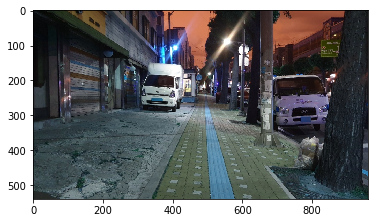

In [8]:
img = cv2.imread(os.path.join(train_dir, sample_image.attrib['name']))
plt.imshow(img)
plt.show()

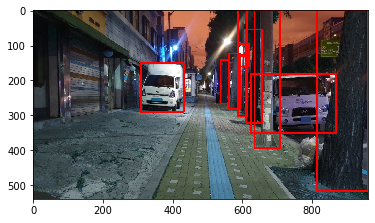

In [9]:
def change_type(x):
    return int(float(x))

for box in iter(sample_image.findall('box')):
    x = (change_type(box.attrib['xtl']), change_type(box.attrib['ytl']))
    y = (change_type(box.attrib['xbr']), change_type(box.attrib['ybr']))
    cv2.rectangle(img, x, y, (255, 0, 0), 4)
plt.imshow(img)
plt.show()

In [10]:
img_name, height, width, label, x1, y1, x2, y2= [], [], [], [], [], [], [], []
box_w, box_h, area = [], [], []
for info in root.findall('image'):
    for box in info.findall('box'):
        img_name.append(info.attrib['name'])
        height.append(int(info.attrib['height']))
        width.append(int(info.attrib['width']))
        label.append(box.attrib['label'])
        x1.append(change_type(box.attrib['xtl']))
        y1.append(change_type(box.attrib['ytl']))
        x2.append(change_type(box.attrib['xbr']))
        y2.append(change_type(box.attrib['ybr']))
        box_w.append(change_type(box.attrib['xbr']) - change_type(box.attrib['xtl']))
        box_h.append(change_type(box.attrib['ybr']) - change_type(box.attrib['ytl']))
        bw = change_type(box.attrib['xbr']) - change_type(box.attrib['xtl'])
        bh = change_type(box.attrib['ybr']) - change_type(box.attrib['ytl'])
        area.append(bw * bh)

image_info = pd.DataFrame({'name': img_name, 'height': np.array(height),
                           'width': np.array(width), 'label': np.array(label),
                          'x1': np.array(x1), 'y1': np.array(y1),
                          'x2': np.array(x2), 'y2': np.array(y2),
                          'box_w': np.array(box_w), 'box_h': np.array(box_h),
                          'area': np.array(area)})

In [11]:
image_info.head()

,name,height,width,label,x1,y1,x2,y2,box_w,box_h,area
0,MP_SEL_236898_B098851.jpg,540,960,truck,624,182,867,352,243,170,41310
1,MP_SEL_236898_B098851.jpg,540,960,traffic_sign,587,96,619,130,32,34,1088
2,MP_SEL_236898_B098851.jpg,540,960,tree_trunk,562,124,592,283,30,159,4770
3,MP_SEL_236898_B098851.jpg,540,960,tree_trunk,537,143,562,267,25,124,3100
4,MP_SEL_236898_B098851.jpg,540,960,pole,634,0,708,394,74,394,29156


In [12]:
image_info.dtypes

name      object
height     int64
width      int64
label     object
x1         int64
y1         int64
x2         int64
y2         int64
box_w      int64
box_h      int64
area       int64
dtype: object

In [13]:
image_info.groupby('label').size()

label
barricade                    16036
bench                        20329
bicycle                      49022
bollard                     269763
bus                          43964
car                         748915
carrier                       9300
cat                            162
chair                        28693
dog                           9869
fire_hydrant                 10524
kiosk                         9167
motorcycle                   57001
movable_signage             124410
parking_meter                  322
person                      402572
pole                        367641
potted_plant                 70412
power_controller              5704
scooter                       1900
stop                         15568
stroller                      5851
table                         8489
traffic_light_controller      6493
traffic_sign                166748
tree_trunk                  390648
truck                       130271
wheelchair                    3739
dtype: int64

In [32]:
bollard = image_info[image_info['label']=='bollard']
bollard_ = image_info[image_info['name'].isin(bollard['name'].unique())]
bollard_ = bollard_[bollard_['label'].isin(['bicycle', 'bollard', 'bus', 'car', 'motorcycle', 'movable_signage',
                                          'person', 'pole', 'potted_plant', 'traffic_sign', 'tree_trunk', 'truck'])]
bollard_.groupby('label').size()

label
bicycle             13694
bollard            269763
bus                 13201
car                216215
motorcycle          15336
movable_signage     39928
person             125367
pole               108473
potted_plant        18509
traffic_sign        57242
tree_trunk          86354
truck               34932
dtype: int64

In [34]:
len(bollard_['name'].unique())

80980

In [38]:
bollard_['name'].unique()

array(['MP_SEL_236900_B098853.jpg', 'MP_SEL_236911_B098862.jpg',
       'MP_SEL_236914_B098864.jpg', ..., 'MP_SEL_B026918.jpg',
       'MP_SEL_B026922.jpg', 'MP_SEL_B026937.jpg'], dtype=object)

In [20]:
tree_img = image_info[image_info['label']=='tree_trunk']
len(tree_img['name'].unique())

154027

In [27]:
# image_info['name'] == tree_img['name'].unique()
tree_name = tree_img['name'].unique()
tree_info = image_info[image_info['name'].isin(tree_name)]

In [28]:
tree_info.groupby('label').size()

label
barricade                     5515
bench                        15064
bicycle                      23549
bollard                     129406
bus                          27005
car                         335934
carrier                       4240
cat                             36
chair                        12959
dog                           4504
fire_hydrant                  6485
kiosk                         5247
motorcycle                   24426
movable_signage              52659
parking_meter                  159
person                      203360
pole                        183864
potted_plant                 23448
power_controller              3733
scooter                        956
stop                         10569
stroller                      2879
table                         4202
traffic_light_controller      3876
traffic_sign                 87833
tree_trunk                  390648
truck                        60165
wheelchair                    2072
dtype: int64

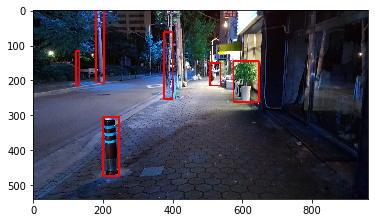

In [40]:
image_id = 'MP_SEL_B026937.jpg'

img = cv2.imread(f'{train_dir}/{image_id}')
sample_image2 = image_info[image_info['name']==image_id].loc[:, ['x1', 'y1', 'x2', 'y2']]

for x1, y1, x2, y2 in np.array(sample_image2):
    x = (x1, y1)
    y = (x2, y2)
    cv2.rectangle(img, x, y, (255, 0, 0), 4)
plt.imshow(img)
plt.show()

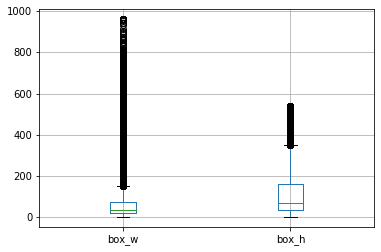

In [14]:
pd.DataFrame(image_info[['box_w', 'box_h']]).boxplot()
plt.show()

In [15]:
image_info[image_info['box_w'] == max(image_info['box_w'])]

,name,height,width,label,x1,y1,x2,y2,box_w,box_h,area
325007,MP_SEL_026237.jpg,540,960,bench,0,404,960,540,960,136,130560
325175,MP_SEL_026251.jpg,540,960,car,0,314,960,540,960,226,216960
331534,MP_SEL_026977.jpg,540,960,barricade,0,448,960,540,960,92,88320
727868,MP_TW_P001192.jpg,540,960,car,0,369,960,540,960,171,164160
750319,MP_TW_P004000.jpg,540,960,truck,0,0,960,540,960,540,518400
751332,MP_TW_P004131.jpg,540,960,car,0,149,960,540,960,391,375360
1833032,MP_SEL_066374.jpg,540,960,car,0,346,960,540,960,194,186240
2086185,MP_KSC_006144.jpg,540,960,stop,0,0,960,274,960,274,263040


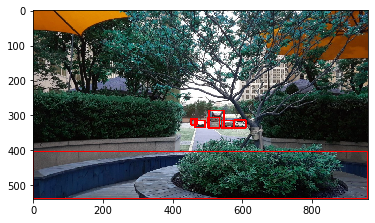

In [16]:
img = cv2.imread(f'{train_dir}/MP_SEL_026237.jpg')
sample_image2 = image_info[image_info['name']=='MP_SEL_026237.jpg'].loc[:, ['x1', 'y1', 'x2', 'y2']]

for x1, y1, x2, y2 in np.array(sample_image2):
    x = (x1, y1)
    y = (x2, y2)
    cv2.rectangle(img, x, y, (255, 0, 0), 4)
plt.imshow(img)
plt.show()

# Save Train / Val csv  

In [6]:
train_df = elemTree.parse(f'{BASE_DIR}/train/train.xml')
val_df = elemTree.parse(f'{BASE_DIR}/val/val.xml')
test_df = elemTree.parse(f'{BASE_DIR}/test/test.xml')
train_root = train_df.getroot()
val_root = val_df.getroot()
test_root = test_df.getroot()
def change_type(x):
    return int(float(x))

In [8]:
class_num = {'bus' : 1, 'car' : 2, 'carrier' : 3, 'cat' : 4, 'dog' : 5, 'motorcycle' : 6, 'movable_signage' : 7,
                     'person' : 8, 'scooter' : 9, 'stroller' : 10, 'truck' : 11, 'wheelchair' : 12, 'barricade' : 13, 'bench' : 14, 'chair' : 15,
                     'ㅁfire_hydrant' : 16, 'kiosk': 17, 'parking_meter' : 18, 'pole': 19, 'potted_plant' : 20, 'power_controller' : 21, 'stop' : 22, 'table' : 23,
                     'traffic_light_controller':24, 'traffic_sign':25, 'tree_trunk':26, 'bollard':27, 'bicycle' : 28}

In [ ]:
img_name, height, width, label, x1, y1, x2, y2= [], [], [], [], [], [], [], []
box_w, box_h, area = [], [], []
for info in train_root.findall('image'):
    for box in info.findall('box'):
        img_name.append(info.attrib['name'])
        height.append(int(info.attrib['height']))
        width.append(int(info.attrib['width']))
        label.append(class_num[box.attrib['label']])
        x1.append(change_type(box.attrib['xtl']))
        y1.append(change_type(box.attrib['ytl']))
        x2.append(change_type(box.attrib['xbr']))
        y2.append(change_type(box.attrib['ybr']))
        box_w.append(change_type(box.attrib['xbr']) - change_type(box.attrib['xtl']))
        box_h.append(change_type(box.attrib['ybr']) - change_type(box.attrib['ytl']))
        bw = change_type(box.attrib['xbr']) - change_type(box.attrib['xtl'])
        bh = change_type(box.attrib['ybr']) - change_type(box.attrib['ytl'])
        area.append(bw * bh)

train_image_info = pd.DataFrame({'name': img_name, 'height': np.array(height),
                           'width': np.array(width), 'label': np.array(label),
                          'x1': np.array(x1), 'y1': np.array(y1),
                          'x2': np.array(x2), 'y2': np.array(y2),
                          'box_w': np.array(box_w), 'box_h': np.array(box_h),
                          'area': np.array(area)})

In [ ]:
train_image_info.head()

In [ ]:
train_image_info.to_csv(f'train.csv', mode='w')

In [ ]:
img_name, height, width, label, x1, y1, x2, y2= [], [], [], [], [], [], [], []
box_w, box_h, area = [], [], []
for info in val_root.findall('image'):
    for box in info.findall('box'):
        img_name.append(info.attrib['name'])
        height.append(int(info.attrib['height']))
        width.append(int(info.attrib['width']))
        label.append(class_num[box.attrib['label']])
        x1.append(change_type(box.attrib['xtl']))
        y1.append(change_type(box.attrib['ytl']))
        x2.append(change_type(box.attrib['xbr']))
        y2.append(change_type(box.attrib['ybr']))
        box_w.append(change_type(box.attrib['xbr']) - change_type(box.attrib['xtl']))
        box_h.append(change_type(box.attrib['ybr']) - change_type(box.attrib['ytl']))
        bw = change_type(box.attrib['xbr']) - change_type(box.attrib['xtl'])
        bh = change_type(box.attrib['ybr']) - change_type(box.attrib['ytl'])
        area.append(bw * bh)

val_image_info = pd.DataFrame({'name': img_name, 'height': np.array(height),
                           'width': np.array(width), 'label': np.array(label),
                          'x1': np.array(x1), 'y1': np.array(y1),
                          'x2': np.array(x2), 'y2': np.array(y2),
                          'box_w': np.array(box_w), 'box_h': np.array(box_h),
                          'area': np.array(area)})

In [ ]:
val_image_info.head()

In [ ]:
val_image_info.to_csv(f'val.csv', mode='w')

In [14]:
test_root.findall('image')[0].findall()

TypeError: Required argument 'path' (pos 1) not found

# Val image 

In [37]:
from tqdm import tqdm
cnt = 0
result = []
for info in tqdm(val_root.findall('image')):
    if info.attrib['name'] == 'ZED3_KSC_052263_L_P012028.png': cnt +=1; continue
    try:
        img = cv2.imread(os.path.join(val_dir, info.attrib['name']))
        result.append(img.shape)
    except AttributeError:
        print(info.attrib['name'])


100%|██████████| 22742/22742 [06:20<00:00, 59.77it/s]


In [38]:
cnt

1

In [34]:
img = cv2.imread(os.path.join(val_dir, val_root.findall('image')[14033].attrib['name']))
img

In [35]:
img

In [36]:
val_root.findall('image')[14033].attrib['name']

'ZED3_KSC_052263_L_P012028.png'